### Importing Libraries

In [44]:
# Pre Processing 
import pandas as pd
import datetime as dt
import numpy as np

# Exploratory Data
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import squarify 
%matplotlib inline

# Pycaret Environment
from pycaret.classification import setup
from pycaret.classification import compare_models
from pycaret.classification import *

### Load Income Dataset

In [2]:
Income = pd.read_csv('income_evaluation.csv')
pd.set_option('display.max_columns', None)
Income.head(6)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


### Renaming Columns of Dataset

In [3]:
# Renaming Columns to their appropriate Names
col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation','relationship','race',
             'sex','capital-gain','capital-loss','hours-per-week','native-country','income']
Income.columns = col_names

col_names

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country',
 'income']

### Dataset Profiling

In [4]:
print("Dataset dimension :", Income.ndim)
print("Dataset shape :", Income.shape)
print("Dataset size :", Income.size)

Dataset dimension : 2
Dataset shape : (32561, 15)
Dataset size : 488415


In [5]:
income_types = Income.dtypes.reset_index()
income_types.columns = ['Features','Data Type']
income_types

,Features,Data Type
0,age,int64
1,workclass,object
2,fnlwgt,int64
3,education,object
4,education-num,int64
5,marital-status,object
6,occupation,object
7,relationship,object
8,race,object
9,sex,object


### Dataset Inspection 

### Checking For Missing and Blank Values

In [6]:
miss_data = Income.isnull().sum().reset_index()
miss_data.columns = ['Features','Missing Values']
blank_data = Income.apply(lambda x: x == ' ').sum().reset_index()
blank_data.columns = ['Features','Blank Values']
merged_data = pd.merge(miss_data,blank_data, on=['Features'])
merged_data['Filling Factor'] = (Income.shape[0]-miss_data['Missing Values'] + Income.shape[0]-blank_data['Blank Values'])/Income.shape[0]*50
merged_data.sort_values(by='Filling Factor',ascending = True)

,Features,Missing Values,Blank Values,Filling Factor
0,age,0,0,100.0
1,workclass,0,0,100.0
2,fnlwgt,0,0,100.0
3,education,0,0,100.0
4,education-num,0,0,100.0
5,marital-status,0,0,100.0
6,occupation,0,0,100.0
7,relationship,0,0,100.0
8,race,0,0,100.0
9,sex,0,0,100.0


### Cross Checking Missing Values with ASSERT Statement

In [7]:
# Assert that there are no missing values in the dataframe

assert pd.notnull(Income).all().all()

Interpretation
 - The above command does not throw any error. Hence, it is confirmed that there are no missing or negative values in the dataset.
 - All the values are greater than or equal to zero excluding character values.

### Dataset Overview

In [8]:
def initial_eda(df):
    if isinstance(df, pd.DataFrame):
        total_na = df.isna().sum().sum()
        print("Dimensions : %d rows, %d columns" % (df.shape[0], df.shape[1]))
        print("Total NA Values : %d " % (total_na))
        print("%38s %10s     %10s %10s" % ("Column Name", "Data Type", "#Distinct", "NA Values"))
        col_name = df.columns
        dtyp = df.dtypes
        uniq = df.nunique()
        na_val = df.isna().sum()
        for i in range(len(df.columns)):
            print("%38s %10s   %10s %10s" % (col_name[i], dtyp[i], uniq[i], na_val[i]))
        
    else:
        print("Expect a DataFrame but got a %15s" % (type(df)))
        
initial_eda(Income)

Dimensions : 32561 rows, 15 columns
Total NA Values : 0 
                           Column Name  Data Type      #Distinct  NA Values
                                   age      int64           73          0
                             workclass     object            9          0
                                fnlwgt      int64        21648          0
                             education     object           16          0
                         education-num      int64           16          0
                        marital-status     object            7          0
                            occupation     object           15          0
                          relationship     object            6          0
                                  race     object            5          0
                                   sex     object            2          0
                          capital-gain      int64          119          0
                          capital-loss      int64    

### Explore Categorical Variables

In [9]:
categorical = [var for var in Income.columns if Income[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :\n\n', categorical)

There are 9 categorical variables

The categorical variables are :

 ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']


### Categorical Variables Distinct Values Distribution

In [10]:
for var in categorical: 
    
    print(Income[var].value_counts())

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64
 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: education, dtype: int64
 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital-status, dtype: int64
 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial

Takeaways
 - Now, we can see that there are several variables like workclass, occupation and native_country which contain missing values.
 - Generally, the missing values are coded as NaN and python will detect them with the usual command of df.isnull().sum().
 - But, in this case the missing values are coded as ?. Python fail to detect these as missing values because it does not consider ? as missing values.
 - So, I have to replace ? with NaN so that Python can detect these missing values.
 - I will explore these variables and replace ? with NaN.

### Data Cleaning 

### `Workclass` Feature Missing Values Handling

In [11]:
# Replace '?' values in workclass variable with `NaN`
Income['workclass'].replace(' ?', np.NaN, inplace=True)

# Replace Nan to value type occurs more frequently than others
Income['workclass'] = Income['workclass'].fillna(value='Private')

# Double Checking Missing
WC_fill = Income['workclass'].isnull().sum()

print('Workclass missing value:', WC_fill)

Workclass missing value: 0


In [12]:
# Cross Checking its distinct value
WC_count = Income['workclass'].value_counts().reset_index()
WC_count.columns = ['workclass','Total Count']
WC_count.sort_values(by='Total Count',ascending=False)

,workclass,Total Count
0,Private,22696
1,Self-emp-not-inc,2541
2,Local-gov,2093
3,Private,1836
4,State-gov,1298
5,Self-emp-inc,1116
6,Federal-gov,960
7,Without-pay,14
8,Never-worked,7


### `Occupation` Feature Missing Values Handling

In [13]:
# Replace '?' values in workclass variable with `NaN`
Income['occupation'].replace(' ?', np.NaN, inplace=True)

# Replace Nan to value type occurs more frequently than others
Income['occupation'] = Income['occupation'].fillna(value='Prof-specialty')

# Double Checking Missing
OC_fill = Income['occupation'].isnull().sum()

print('Occupation missing value:', OC_fill)

Occupation missing value: 0


In [14]:
# Cross Checking its distinct value
OC_count = Income['occupation'].value_counts().reset_index()
OC_count.columns = ['occupation','Total Count']
OC_count.sort_values(by='Total Count',ascending=False)

,occupation,Total Count
0,Prof-specialty,4140
1,Craft-repair,4099
2,Exec-managerial,4066
3,Adm-clerical,3770
4,Sales,3650
5,Other-service,3295
6,Machine-op-inspct,2002
7,Prof-specialty,1843
8,Transport-moving,1597
9,Handlers-cleaners,1370


### `Native-country` Missing Values Handling

In [15]:
# Replace '?' values in workclass variable with `NaN`
Income['native-country'].replace(' ?', np.NaN, inplace=True)

# Replace Nan to value type occurs more frequently than others
Income['native-country'] = Income['native-country'].fillna(value='United-States')

# Double Checking Missing
NC_fill = Income['native-country'].isnull().sum()

print('Native-country missing value:', NC_fill)

Native-country missing value: 0


In [16]:
# Cross Checking its distinct value
NC_count = Income['native-country'].value_counts().reset_index()
NC_count.columns = ['native-country','Total Count']
NC_count.sort_values(by='Total Count',ascending=False)

,native-country,Total Count
0,United-States,29170
1,Mexico,643
2,United-States,583
3,Philippines,198
4,Germany,137
5,Canada,121
6,Puerto-Rico,114
7,El-Salvador,106
8,India,100
9,Cuba,95


### Exploratory Data

### Dataset Basic Statistic

In [17]:
Income.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


### Numerical Feature Plot

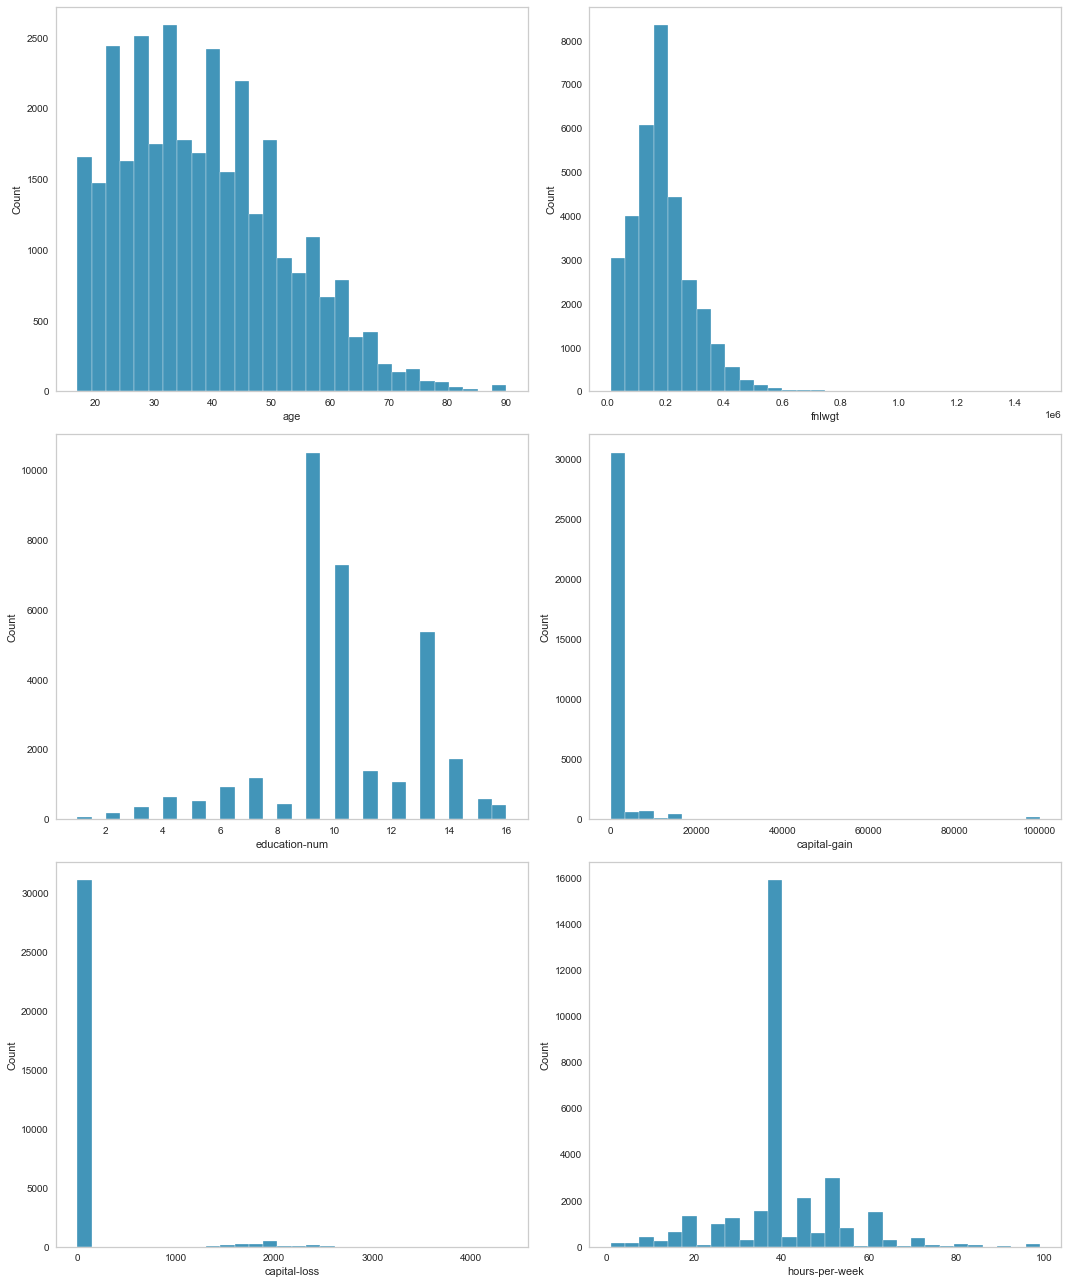

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

Income_num = Income[['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']]

plt.figure(figsize=(15, 18))
for i in range(0, len(list(Income_num))):
    plt.subplot(3, 2, i+1)
    sns.histplot(x=Income[list(Income_num)[i]],bins = 30)
    plt.tight_layout()

### Outliers 

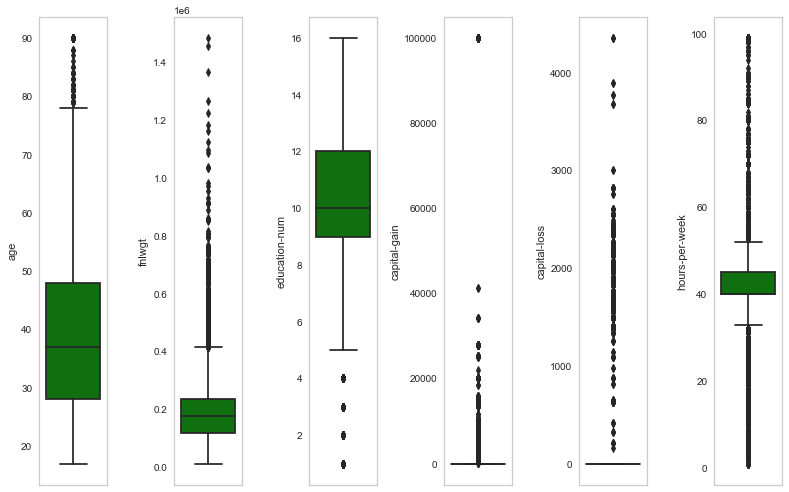

In [19]:
plt.figure(figsize=(13, 7))
for i in range(0, len(list(Income_num))):
    plt.subplot(1, 7, i+1)
    sns.boxplot(y=Income[list(Income_num)[i]],color='green',orient='v')
    plt.tight_layout()

### Correlation

In [20]:
# plot correlation heatmap to find out correlations

Income.corr().style.format("{:.4}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.0,-0.07665,0.03653,0.07767,0.05777,0.06876
fnlwgt,-0.07665,1.0,-0.04319,0.0004319,-0.01025,-0.01877
education-num,0.03653,-0.04319,1.0,0.1226,0.07992,0.1481
capital-gain,0.07767,0.0004319,0.1226,1.0,-0.03162,0.07841
capital-loss,0.05777,-0.01025,0.07992,-0.03162,1.0,0.05426
hours-per-week,0.06876,-0.01877,0.1481,0.07841,0.05426,1.0


### Occupation and Workclass Distribution

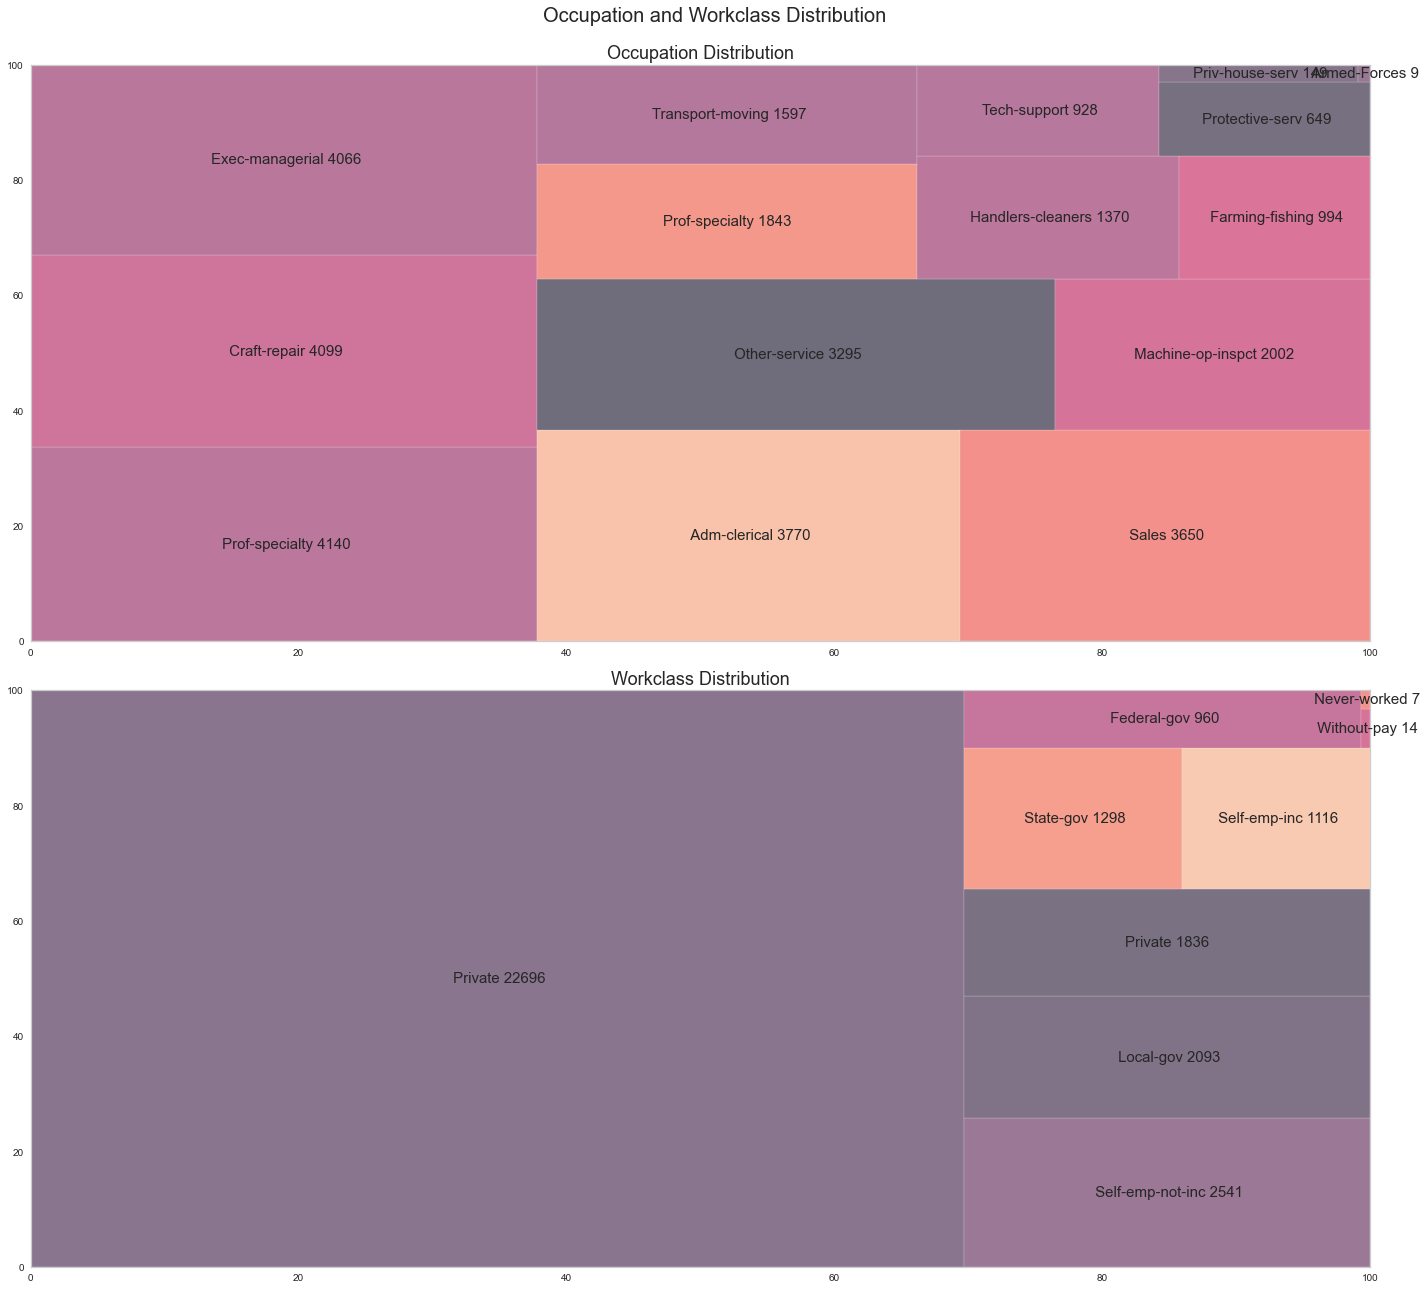

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(20,18))
fig.suptitle("Occupation and Workclass Distribution", fontsize=20, verticalalignment="bottom")
 
#Plot 1
plt.subplot(2,1,1)
size = Income.groupby('occupation',)['occupation'].count().sort_values(ascending= False).tolist() 
label = Income.groupby('occupation',)['occupation'].count().sort_values(ascending= False).index.values.tolist()
label = [i+" "+j for i, j in zip(label, [str(x) for x in size])]
ax1 = squarify.plot(sizes=size, label=label, alpha=.6, text_kwargs={'fontsize':15})
ax1.set_title('Occupation Distribution', fontsize=18, fontweight='normal')

#Plot 2
plt.subplot(2,1,2)
size2 = Income.groupby('workclass',)['workclass'].count().sort_values(ascending= False).tolist() 
label2 = Income.groupby('workclass',)['workclass'].count().sort_values(ascending= False).index.values.tolist()
label2 = [i+" "+j for i, j in zip(label2, [str(x) for x in size2])]
ax2 = squarify.plot(sizes=size2, label=label2, alpha=.6, text_kwargs={'fontsize':15})
ax2.set_title('Workclass Distribution', fontsize=18, fontweight='normal')

plt.tight_layout()

### Education Distribution

Text(0.5, 1.0, 'Education Distribution')

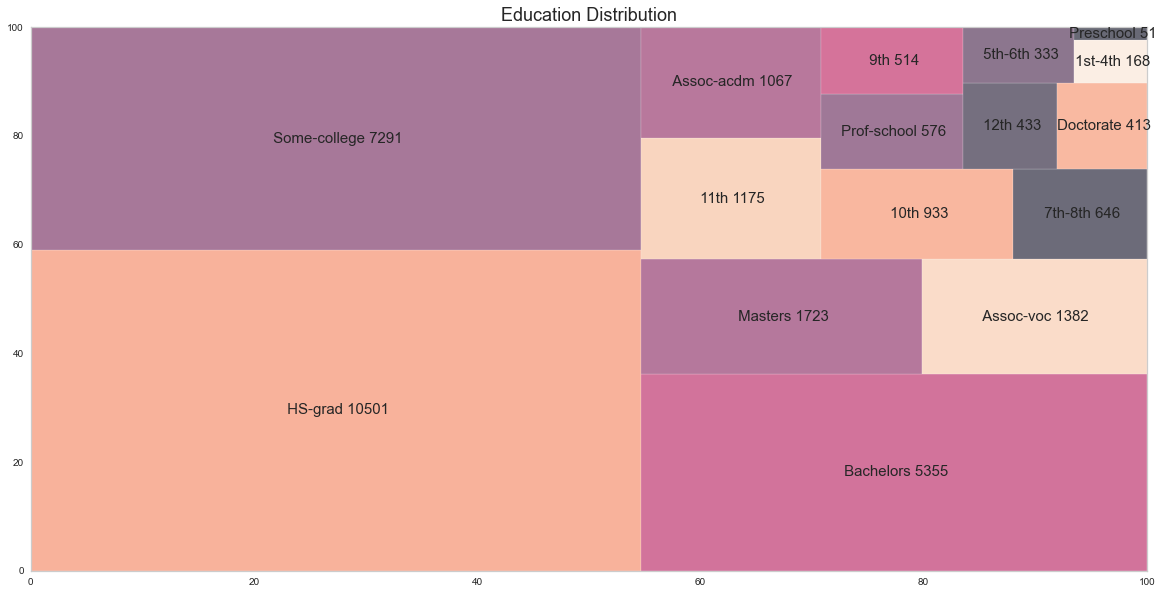

In [22]:
#Plot 3
fig3=plt.figure(figsize=(20,10))
size3 = Income.groupby('education',)['education'].count().sort_values(ascending= False).tolist() 
label3 = Income.groupby('education',)['education'].count().sort_values(ascending= False).index.values.tolist()
label3 = [i+" "+j for i, j in zip(label3, [str(x) for x in size3])]
ax3 = squarify.plot(sizes=size3, label=label3, alpha=.6, text_kwargs={'fontsize':15})
ax3.set_title('Education Distribution', fontsize=18, fontweight='normal')

### Native-country Distribution

Text(0.5, 1.0, 'Native-country Distribution')

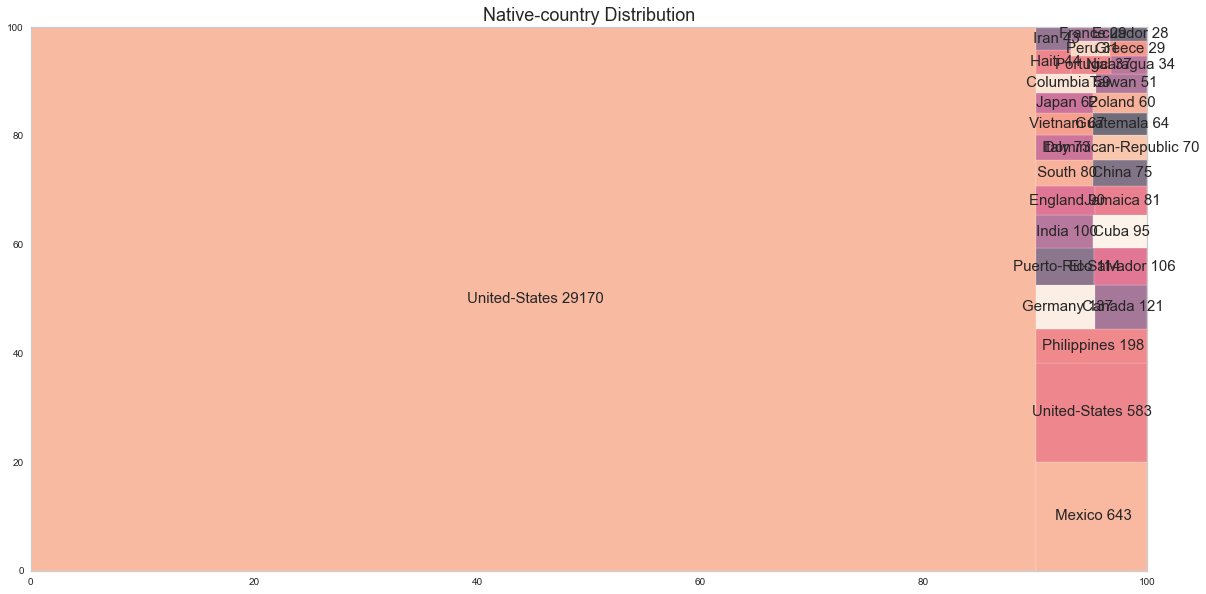

In [23]:
#Plot 4
fig4=plt.figure(figsize=(20,10))
size4 = Income.groupby('native-country',)['native-country'].count().sort_values(ascending= False)[:30].tolist() 
label4 = Income.groupby('native-country',)['native-country'].count().sort_values(ascending= False)[:30].index.values.tolist()
label4 = [i+" "+j for i, j in zip(label4, [str(x) for x in size4])]
ax4 = squarify.plot(sizes=size4, label=label4, alpha=.6, text_kwargs={'fontsize':15})
ax4.set_title('Native-country Distribution', fontsize=18, fontweight='normal')

### Income Disribution

Text(0.5, 1.0, 'Income Distribution')

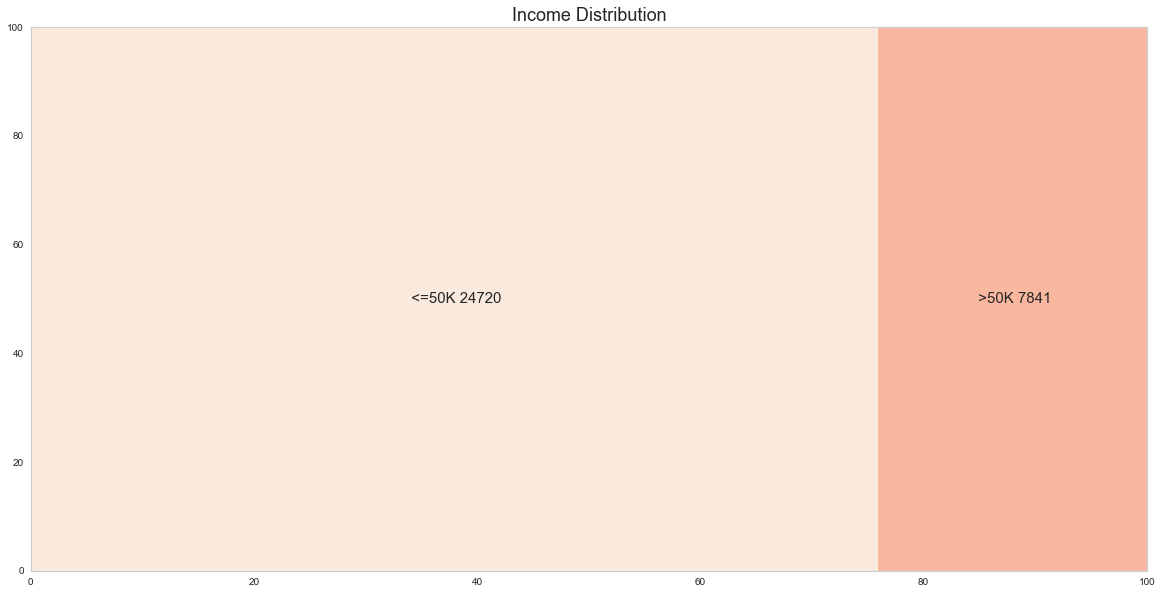

In [24]:
#Plot 5
fig5=plt.figure(figsize=(20,10))
size5 = Income.groupby('income',)['income'].count().sort_values(ascending= False)[:30].tolist() 
label5 = Income.groupby('income',)['income'].count().sort_values(ascending= False)[:30].index.values.tolist()
label5 = [i+" "+j for i, j in zip(label5, [str(x) for x in size5])]
ax5 = squarify.plot(sizes=size5, label=label5, alpha=.6, text_kwargs={'fontsize':15})
ax5.set_title('Income Distribution', fontsize=18, fontweight='normal')

### Categorical Plotting In Respect to Target Feature (Income)

### Frequency Distribution of Income per Education

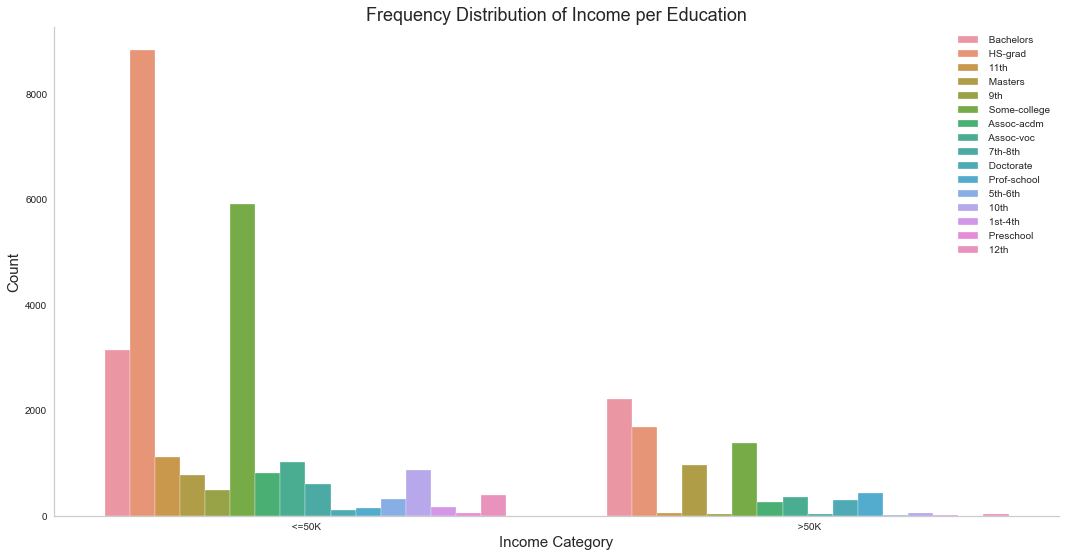

In [25]:
fig12=plt.figure(figsize=(18,9))
ax12 = sns.countplot(x='income', hue='education', data=Income)
ax12.set_ylabel('Count',fontsize=15,fontweight='normal')    
ax12.set_xlabel('Income Category',fontsize=15,fontweight='normal') 
ax12.spines['right'].set_visible(False)
ax12.spines['top'].set_visible(False)
ax12.set_title('Frequency Distribution of Income per Education',fontsize=18, fontweight='normal')
ax12.legend(loc='upper right')

### Frequency Distribution of Income Category per Occupation and Workclass

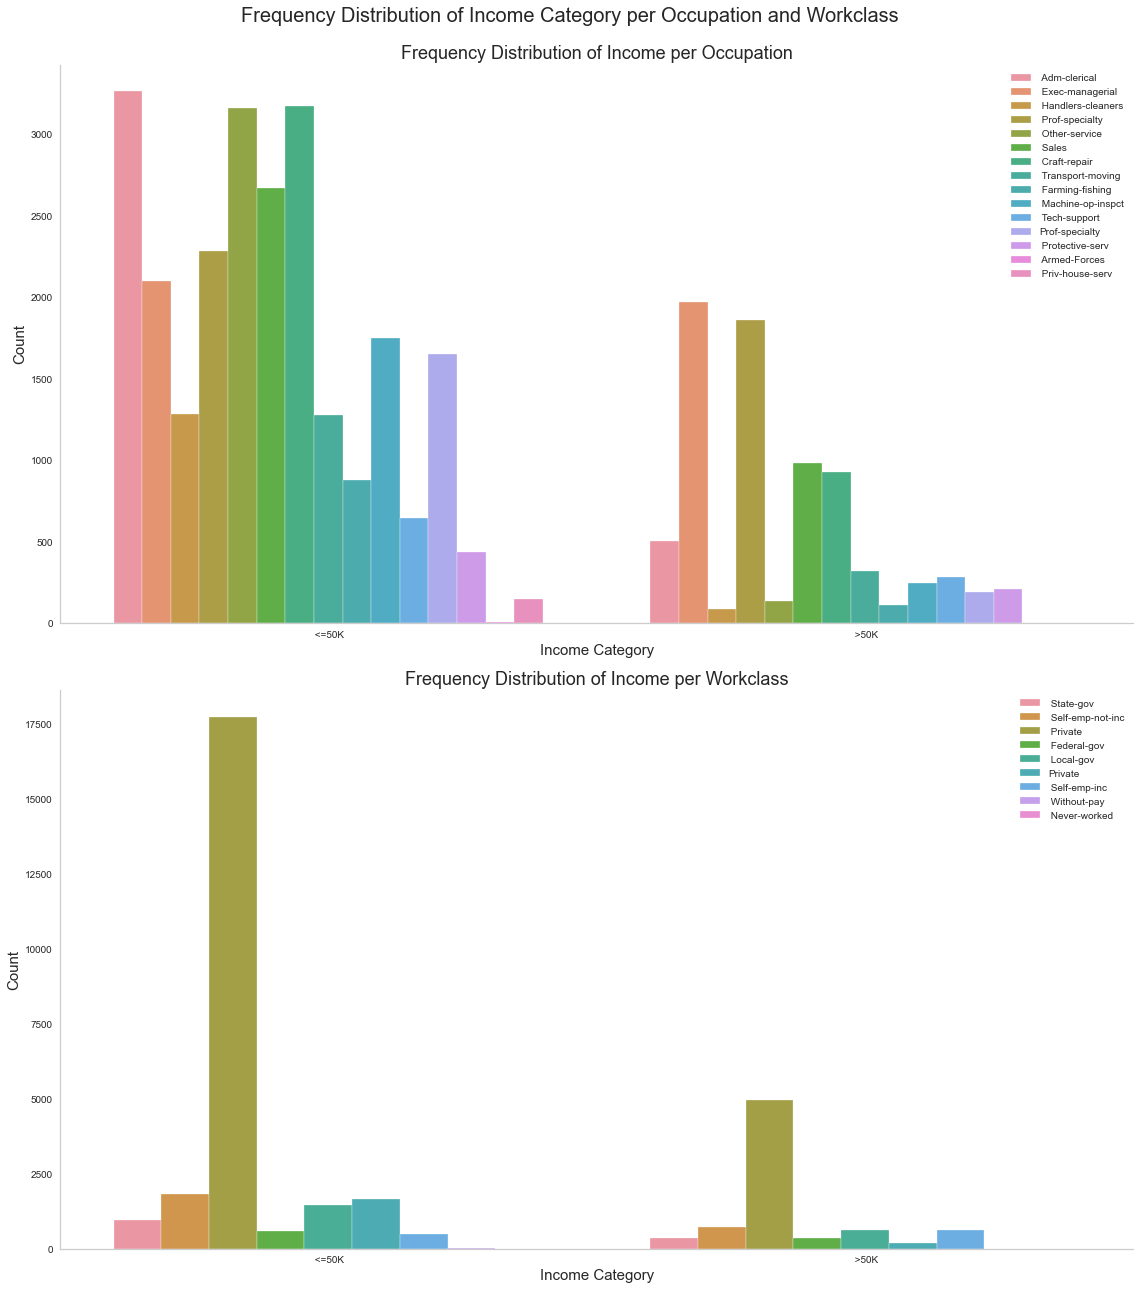

In [26]:
fig, (ax6, ax7) = plt.subplots(2, 1,figsize=(16,18))
fig.suptitle("Frequency Distribution of Income Category per Occupation and Workclass", fontsize=20, verticalalignment="bottom")
 
#Plot 1
ax6 = sns.countplot(x='income', hue='occupation',ax=ax6, data=Income)
ax6.set_ylabel('Count',fontsize=15,fontweight='normal')    
ax6.set_xlabel('Income Category',fontsize=15,fontweight='normal') 
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)
ax6.set_title('Frequency Distribution of Income per Occupation',fontsize=18, fontweight='normal')
ax6.legend(loc='best')


#Plot 2
ax7 = sns.countplot(x='income', hue='workclass',ax=ax7, data=Income)
ax7.set_ylabel('Count',fontsize=15,fontweight='normal')    
ax7.set_xlabel('Income Category',fontsize=15,fontweight='normal') 
ax7.spines['right'].set_visible(False)
ax7.spines['top'].set_visible(False)
ax7.set_title('Frequency Distribution of Income per Workclass',fontsize=18, fontweight='normal')
ax7.legend(loc='upper right')

plt.tight_layout()

### Frequency Distribution of Income Category per Sex and Race

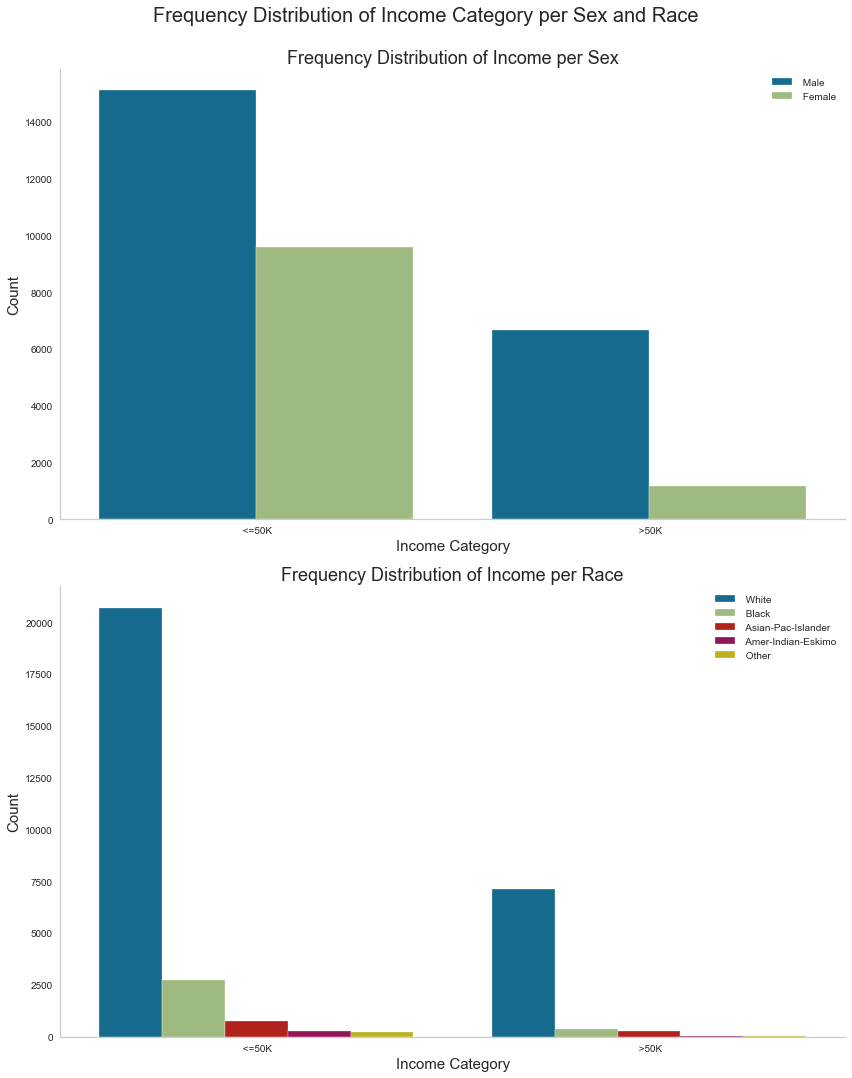

In [27]:
fig, (ax8, ax9) = plt.subplots(2, 1,figsize=(12,15))
fig.suptitle("Frequency Distribution of Income Category per Sex and Race", fontsize=20, verticalalignment="bottom")
 
#Plot 1
ax8 = sns.countplot(x='income', hue='sex',ax=ax8, data=Income)
ax8.set_ylabel('Count',fontsize=15,fontweight='normal')    
ax8.set_xlabel('Income Category',fontsize=15,fontweight='normal') 
ax8.spines['right'].set_visible(False)
ax8.spines['top'].set_visible(False)
ax8.set_title('Frequency Distribution of Income per Sex',fontsize=18, fontweight='normal')
ax8.legend(loc='best')


#Plot 2
ax9 = sns.countplot(x='income', hue='race',ax=ax9, data=Income)
ax9.set_ylabel('Count',fontsize=15,fontweight='normal')    
ax9.set_xlabel('Income Category',fontsize=15,fontweight='normal') 
ax9.spines['right'].set_visible(False)
ax9.spines['top'].set_visible(False)
ax9.set_title('Frequency Distribution of Income per Race',fontsize=18, fontweight='normal')
ax9.legend(loc='best')

plt.tight_layout()

### Frequency Distribution of Income per Relationship and Marital-status

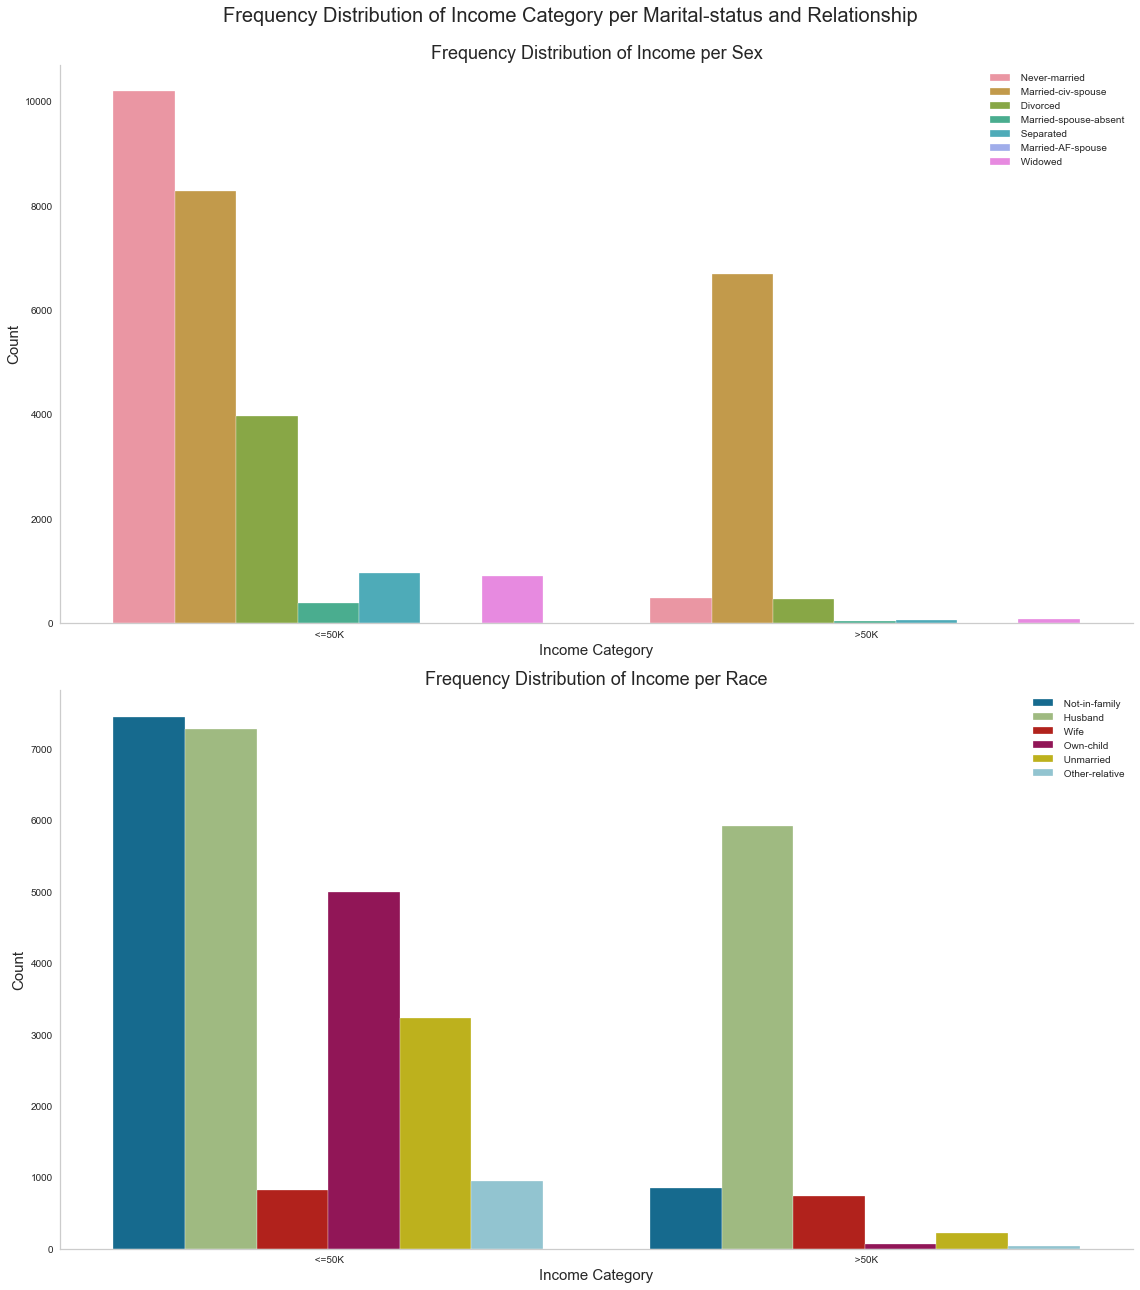

In [28]:
fig, (ax10, ax11) = plt.subplots(2, 1,figsize=(16,18))
fig.suptitle("Frequency Distribution of Income Category per Marital-status and Relationship", fontsize=20, verticalalignment="bottom")
 
#Plot 1
ax10 = sns.countplot(x='income', hue='marital-status',ax=ax10, data=Income)
ax10.set_ylabel('Count',fontsize=15,fontweight='normal')    
ax10.set_xlabel('Income Category',fontsize=15,fontweight='normal') 
ax10.spines['right'].set_visible(False)
ax10.spines['top'].set_visible(False)
ax10.set_title('Frequency Distribution of Income per Sex',fontsize=18, fontweight='normal')
ax10.legend(loc='best')


#Plot 2
ax11 = sns.countplot(x='income', hue='relationship',ax=ax11, data=Income)
ax11.set_ylabel('Count',fontsize=15,fontweight='normal')    
ax11.set_xlabel('Income Category',fontsize=15,fontweight='normal') 
ax11.spines['right'].set_visible(False)
ax11.spines['top'].set_visible(False)
ax11.set_title('Frequency Distribution of Income per Race',fontsize=18, fontweight='normal')
ax11.legend(loc='best')

plt.tight_layout()

### Prepare Data For Machine Learning

### Imbalance Target Feature Data Checking

In [29]:
print('Distinct value(s) of Income : ', Income['income'].unique())
print(Income['income'].value_counts()/float(len(Income)))

Distinct value(s) of Income :  [' <=50K' ' >50K']
 <=50K    0.75919
 >50K     0.24081
Name: income, dtype: float64


 - It is rather an imbalanced data.
 - Accuracy will not be the best tool to measure performance of the model. Precision, Recall and F1 Score are preferable.

In [30]:
Income['income'] = Income['income'].replace([' <=50K',' >50K'],[0,1])
Income['income'] = Income['income'].astype(np.int64)

print('Distinc value(s) of Income : ', Income['income'].unique())
print(Income['income'].value_counts())

Distinc value(s) of Income :  [0 1]
0    24720
1     7841
Name: income, dtype: int64


### Splitting Dataset to Train dan Test Set

In [31]:
X = Income.drop(['income'], axis=1)
Y = Income['income']

In [32]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Splitting to Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=50)

### Train and Test Set Profiling

In [33]:
print("Train set dimension :", X_train.ndim)
print("Train set shape :", X_train.shape)
print("Train set size :", X_train.size)

Train set dimension : 2
Train set shape : (24420, 14)
Train set size : 341880


In [34]:
print("Test set dimension :", X_test.ndim)
print("Test set shape :", X_test.shape)
print("Test set size :", X_test.size)

Test set dimension : 2
Test set shape : (8141, 14)
Test set size : 113974


### Defining Numerical and Categorical Features

In [35]:
categorical = [col for col in X_train.columns if X_train[col].dtypes == 'O']

categorical

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [36]:
numerical = [col for col in X_train.columns if X_train[col].dtypes != 'O']

numerical

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

### Data Preprocessing : Custom Pipeline Transformation

In [ ]:
pip install --upgrade category_encoders

### Categorical Encoder

In [37]:
# import category encoders
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder


# Encode categorical variables with one-hot encoding
encoder = ce.OneHotEncoder(cols=['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country'])
X_train = encoder.fit_transform(X_train)
X_train

,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,workclass_9,fnlwgt,education_1,education_2,education_3,education_4,education_5,education_6,education_7,education_8,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16,education-num,marital-status_1,marital-status_2,marital-status_3,marital-status_4,marital-status_5,marital-status_6,marital-status_7,occupation_1,occupation_2,occupation_3,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13,occupation_14,occupation_15,relationship_1,relationship_2,relationship_3,relationship_4,relationship_5,relationship_6,race_1,race_2,race_3,race_4,race_5,sex_1,sex_2,capital-gain,capital-loss,hours-per-week,native-country_1,native-country_2,native-country_3,native-country_4,native-country_5,native-country_6,native-country_7,native-country_8,native-country_9,native-country_10,native-country_11,native-country_12,native-country_13,native-country_14,native-country_15,native-country_16,native-country_17,native-country_18,native-country_19,native-country_20,native-country_21,native-country_22,native-country_23,native-country_24,native-country_25,native-country_26,native-country_27,native-country_28,native-country_29,native-country_30,native-country_31,native-country_32,native-country_33,native-country_34,native-country_35,native-country_36,native-country_37,native-country_38,native-country_39,native-country_40,native-country_41,native-country_42
6217,55,1,0,0,0,0,0,0,0,0,138594,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1977,45,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24569,35,0,1,0,0,0,0,0,0,0,150042,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,40,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5534,39,0,1,0,0,0,0,0,0,0,340091,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,75,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1726,55,0,1,0,0,0,0,0,0,0,199067,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,40,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10136,36,0,0,1,0,0,0,0,0,0,151322,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,45,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15649,37,0,0,0,0,0,0,1,0,0,173192,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,11,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,40,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22637,53,0,0,1,0,0,0,0,0,0,284329,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,50,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10123,47,0,1,0,0,0,0,0,0,0,74305,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,40,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5600,44,0,1,0,0,0,0,0,0,0,376072,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,45,1,0,0,

In [38]:
# For Test Set
X_test = encoder.transform(X_test)
X_test

,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,workclass_9,fnlwgt,education_1,education_2,education_3,education_4,education_5,education_6,education_7,education_8,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16,education-num,marital-status_1,marital-status_2,marital-status_3,marital-status_4,marital-status_5,marital-status_6,marital-status_7,occupation_1,occupation_2,occupation_3,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13,occupation_14,occupation_15,relationship_1,relationship_2,relationship_3,relationship_4,relationship_5,relationship_6,race_1,race_2,race_3,race_4,race_5,sex_1,sex_2,capital-gain,capital-loss,hours-per-week,native-country_1,native-country_2,native-country_3,native-country_4,native-country_5,native-country_6,native-country_7,native-country_8,native-country_9,native-country_10,native-country_11,native-country_12,native-country_13,native-country_14,native-country_15,native-country_16,native-country_17,native-country_18,native-country_19,native-country_20,native-country_21,native-country_22,native-country_23,native-country_24,native-country_25,native-country_26,native-country_27,native-country_28,native-country_29,native-country_30,native-country_31,native-country_32,native-country_33,native-country_34,native-country_35,native-country_36,native-country_37,native-country_38,native-country_39,native-country_40,native-country_41,native-country_42
5627,35,0,0,0,1,0,0,0,0,0,215419,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,40,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29006,67,0,0,1,0,0,0,0,0,0,431426,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,12,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,20051,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10922,43,0,0,1,0,0,0,0,0,0,150528,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,30,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31192,31,0,1,0,0,0,0,0,0,0,128567,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,40,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20253,56,0,0,1,0,0,0,0,0,0,144380,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,50,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15221,36,0,1,0,0,0,0,0,0,0,268620,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,33,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5344,61,0,0,0,0,0,1,0,0,0,226989,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,40,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22215,19,0,0,0,0,0,0,0,1,0,43887,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20,40,0,1,0,0,0,0,0,0,0,193524,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,60,1,0,0,

### Feature Scaling

In [39]:
cols = X_train.columns

from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=[cols])
X_train

,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,workclass_9,fnlwgt,education_1,education_2,education_3,education_4,education_5,education_6,education_7,education_8,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16,education-num,marital-status_1,marital-status_2,marital-status_3,marital-status_4,marital-status_5,marital-status_6,marital-status_7,occupation_1,occupation_2,occupation_3,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13,occupation_14,occupation_15,relationship_1,relationship_2,relationship_3,relationship_4,relationship_5,relationship_6,race_1,race_2,race_3,race_4,race_5,sex_1,sex_2,capital-gain,capital-loss,hours-per-week,native-country_1,native-country_2,native-country_3,native-country_4,native-country_5,native-country_6,native-country_7,native-country_8,native-country_9,native-country_10,native-country_11,native-country_12,native-country_13,native-country_14,native-country_15,native-country_16,native-country_17,native-country_18,native-country_19,native-country_20,native-country_21,native-country_22,native-country_23,native-country_24,native-country_25,native-country_26,native-country_27,native-country_28,native-country_29,native-country_30,native-country_31,native-country_32,native-country_33,native-country_34,native-country_35,native-country_36,native-country_37,native-country_38,native-country_39,native-country_40,native-country_41,native-country_42
0,0.90,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.335870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1977.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.240570,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.341497,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.167539,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.05,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.229915,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [40]:
# For Test Set
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=[cols])
X_test

,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,workclass_9,fnlwgt,education_1,education_2,education_3,education_4,education_5,education_6,education_7,education_8,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16,education-num,marital-status_1,marital-status_2,marital-status_3,marital-status_4,marital-status_5,marital-status_6,marital-status_7,occupation_1,occupation_2,occupation_3,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13,occupation_14,occupation_15,relationship_1,relationship_2,relationship_3,relationship_4,relationship_5,relationship_6,race_1,race_2,race_3,race_4,race_5,sex_1,sex_2,capital-gain,capital-loss,hours-per-week,native-country_1,native-country_2,native-country_3,native-country_4,native-country_5,native-country_6,native-country_7,native-country_8,native-country_9,native-country_10,native-country_11,native-country_12,native-country_13,native-country_14,native-country_15,native-country_16,native-country_17,native-country_18,native-country_19,native-country_20,native-country_21,native-country_22,native-country_23,native-country_24,native-country_25,native-country_26,native-country_27,native-country_28,native-country_29,native-country_30,native-country_31,native-country_32,native-country_33,native-country_34,native-country_35,native-country_36,native-country_37,native-country_38,native-country_39,native-country_40,native-country_41,native-country_42
0,-0.10,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.303662,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.50,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.101817,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,20051.0,0.0,-7.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.30,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.236525,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.419340,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.95,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.287704,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

### Machine Learning Model on Training Set

In [41]:
X_train.columns = X_train.columns.get_level_values(0)
X_test.columns = X_test.columns.get_level_values(0)

### Random Forest (Deafult Parameter)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
from sklearn.metrics import accuracy_score

# Choosing Model
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=50)
forest_clf.fit(X_train, y_train)
predictions = forest_clf.predict(X_train)

# Evaluating Model Selection
print('*****************Train*******************')
print('Train Accuracy',accuracy_score(y_train, predictions))
print('Train Precision',precision_score(y_train, predictions))
print('Train Recall',recall_score(y_train, predictions))
print('Train F1 Score',f1_score(y_train, predictions))
print('****************************************')
# Predit Test Set
final_predictions = forest_clf.predict(X_test)

# Model Evaluation Test Set
print('******************Test*******************')
print('Test Accuracy',accuracy_score(y_test, final_predictions))
print('Test Precision',precision_score(y_test, final_predictions))
print('Test Recall',recall_score(y_test, final_predictions))
print('Test F1 Score',f1_score(y_test, final_predictions))
print('*****************************************')

### Random Forest (100 Estimators)

In [ ]:
# Choosing Model
from sklearn.ensemble import RandomForestClassifier
forest_clf100 = RandomForestClassifier(random_state=50,n_estimators=100)
forest_clf100.fit(X_train, y_train)
predictions = forest_clf100.predict(X_train)

# Evaluating Model Selection
print('*****************Train*******************')
print('Train Accuracy',accuracy_score(y_train, predictions))
print('Train Precision',precision_score(y_train, predictions))
print('Train Recall',recall_score(y_train, predictions))
print('Train F1 Score',f1_score(y_train, predictions))
print('****************************************')
# Predit Test Set
final_predictions = forest_clf100.predict(X_test)

# Model Evaluation Test Set
print('******************Test*******************')
print('Test Accuracy',accuracy_score(y_test, final_predictions))
print('Test Precision',precision_score(y_test, final_predictions))
print('Test Recall',recall_score(y_test, final_predictions))
print('Test F1 Score',f1_score(y_test, final_predictions))
print('*****************************************')

### SGB Model

In [ ]:
# Choosing Model
from sklearn.ensemble import GradientBoostingClassifier
SGB_clf = GradientBoostingClassifier()
SGB_clf.fit(X_train, y_train)
predictions = SGB_clf.predict(X_train)

# Evaluating Model Selection
print('*****************Train*******************')
print('Train Accuracy',accuracy_score(y_train, predictions))
print('Train Precision',precision_score(y_train, predictions))
print('Train Recall',recall_score(y_train, predictions))
print('Train F1 Score',f1_score(y_train, predictions))
print('****************************************')
# Predit Test Set
final_predictions = SGB_clf.predict(X_test)

# Model Evaluation Test Set
print('******************Test*******************')
print('Test Accuracy',accuracy_score(y_test, final_predictions))
print('Test Precision',precision_score(y_test, final_predictions))
print('Test Recall',recall_score(y_test, final_predictions))
print('Test F1 Score',f1_score(y_test, final_predictions))
print('*****************************************')

### LightGBM Model

In [ ]:
# Choosing Model
import lightgbm as lgb
LGBM_clf = lgb.LGBMClassifier()
LGBM_clf.fit(X_train, y_train)
predictions = LGBM_clf.predict(X_train)

# Evaluating Model Selection
print('*****************Train*******************')
print('Train Accuracy',accuracy_score(y_train, predictions))
print('Train Precision',precision_score(y_train, predictions))
print('Train Recall',recall_score(y_train, predictions))
print('Train F1 Score',f1_score(y_train, predictions))
print('****************************************')
# Predit Test Set
final_predictions = LGBM_clf.predict(X_test)

# Model Evaluation Test Set
print('******************Test*******************')
print('Test Accuracy',accuracy_score(y_test, final_predictions))
print('Test Precision',precision_score(y_test, final_predictions))
print('Test Recall',recall_score(y_test, final_predictions))
print('Test F1 Score',f1_score(y_test, final_predictions))
print('*****************************************')

### Find Importance Features with Random Forest Model

In [ ]:
# view the feature scores using 100 estimators
forest_clf100 = RandomForestClassifier(random_state=50,n_estimators=100)
forest_clf100.fit(X_train, y_train)
predictions = forest_clf100.predict(X_train)

feature_scores = pd.Series(forest_clf100.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print(feature_scores.to_string())

 - We can see that the most important feature is fnlwgt and least important feature is native_country_42.

### Find Importance Features with SGB Model

In [ ]:
# view the feature scores using 100 estimators
SGB_clf = GradientBoostingClassifier()
SGB_clf.fit(X_train, y_train)
predictions = SGB_clf.predict(X_train)

feature_scores2 = pd.Series(SGB_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print(feature_scores2.to_string())

### Find Importances Features with LightGBM Model

In [ ]:
# view the feature scores using 100 estimators
LGBM_clf = lgb.LGBMClassifier()
LGBM_clf.fit(X_train, y_train)
predictions = LGBM_clf.predict(X_train)

feature_scores3 = pd.Series(LGBM_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print(feature_scores3.to_string())

### Model Implementation using PyCaret

### Setting Up Pycaret Environment

### Data Preprocessing with Pycaret

In [47]:
# Preprocessing 
grid = setup(data=Income , target= 'income', data_split_shuffle= True, data_split_stratify= True, session_id= 50,
             high_cardinality_features = ['native-country'], normalize = True, normalize_method = 'robust',
            ignore_low_variance = True, fix_imbalance = False, remove_outliers = False) 

,Description,Value
0,session_id,50
1,Target,income
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(32561, 15)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,9
8,Ordinal Features,False
9,High Cardinality Features,True


### Comparing Models Performances

In [48]:
## Evaluate and compare models
best = compare_models(n_select = 3, sort = 'auc')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8412,0.8931,0.6003,0.6986,0.6452,0.5438,0.5467,0.0920
gbc,Gradient Boosting Classifier,0.8378,0.8911,0.5374,0.7186,0.6143,0.5145,0.5235,0.6560
ada,Ada Boost Classifier,0.8364,0.8902,0.5693,0.6967,0.6260,0.5228,0.5275,0.2030
lr,Logistic Regression,0.8353,0.8876,0.5608,0.6970,0.6210,0.5175,0.5228,0.7620
lda,Linear Discriminant Analysis,0.8320,0.8823,0.5527,0.6891,0.6128,0.5073,0.5127,0.0840
rf,Random Forest Classifier,0.8264,0.8725,0.5640,0.6650,0.6101,0.4995,0.5024,0.4770
et,Extra Trees Classifier,0.8129,0.8529,0.5629,0.6241,0.5917,0.4708,0.4720,0.5720
knn,K Neighbors Classifier,0.8185,0.8381,0.5848,0.6346,0.6083,0.4905,0.4915,0.8330
nb,Naive Bayes,0.5960,0.8220,0.9244,0.3660,0.5244,0.2738,0.3647,0.0200
dt,Decision Tree Classifier,0.7780,0.6984,0.5447,0.5389,0.5417,0.3953,0.3953,0.0520


### Creating ML Models

### LGBM Classifier

In [49]:
LGBM = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8333,0.8874,0.5501,0.6943,0.6138,0.5094,0.5150
1,0.8303,0.8896,0.5647,0.6769,0.6157,0.5079,0.5113
2,0.8355,0.8897,0.5902,0.6835,0.6334,0.5281,0.5305
3,0.8508,0.9013,0.6576,0.7037,0.6798,0.5827,0.5833
4,0.8381,0.8867,0.5774,0.6982,0.6321,0.5295,0.5334
5,0.8486,0.8940,0.6157,0.7161,0.6621,0.5653,0.5679
6,0.8429,0.9032,0.6175,0.6961,0.6544,0.5533,0.5549
7,0.8486,0.8917,0.6193,0.7143,0.6634,0.5664,0.5688
8,0.8521,0.9017,0.5920,0.7420,0.6586,0.5657,0.5716


In [50]:
print(LGBM)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=50, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


### GBC Classifier

In [51]:
GBC = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8276,0.8854,0.4791,0.7108,0.5724,0.4695,0.4838
1,0.8333,0.8869,0.5118,0.7150,0.5966,0.4952,0.5062
2,0.8302,0.8840,0.5282,0.6938,0.5998,0.4945,0.5019
3,0.8495,0.9005,0.5974,0.7289,0.6567,0.5615,0.5660
4,0.8333,0.8833,0.5100,0.7161,0.5957,0.4944,0.5057
5,0.8434,0.8936,0.5501,0.7330,0.6285,0.5318,0.5406
6,0.8412,0.9013,0.5647,0.7159,0.6314,0.5319,0.5380
7,0.8407,0.8906,0.5337,0.7325,0.6175,0.5200,0.5304
8,0.8469,0.9009,0.5337,0.7591,0.6267,0.5341,0.5472


In [52]:
print(GBC)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


### Adaboost Classifier

In [53]:
ADA = create_model('ada')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8276,0.8840,0.5082,0.6940,0.5868,0.4811,0.4904
1,0.8237,0.8864,0.5392,0.6652,0.5956,0.4844,0.4888
2,0.8293,0.8822,0.5574,0.6770,0.6114,0.5033,0.5072
3,0.8460,0.8997,0.6230,0.7037,0.6609,0.5617,0.5635
4,0.8346,0.8824,0.5355,0.7067,0.6093,0.5069,0.5148
5,0.8381,0.8918,0.5738,0.7000,0.6306,0.5283,0.5325
6,0.8447,0.9009,0.6066,0.7070,0.6529,0.5536,0.5563
7,0.8372,0.8876,0.5792,0.6943,0.6316,0.5282,0.5318
8,0.8517,0.9029,0.5738,0.7518,0.6508,0.5588,0.5670


In [54]:
print(ADA)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=50)


### Models Hyperparameter Tuning

### LGBM Classifier

In [55]:
tuned_LGBM = tune_model(LGBM, optimize = 'F1', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8333,0.8855,0.5155,0.7128,0.5983,0.4966,0.5069
1,0.8272,0.8869,0.5282,0.6824,0.5955,0.4879,0.4943
2,0.8390,0.8850,0.5902,0.6953,0.6384,0.5357,0.5387
3,0.8486,0.9002,0.6321,0.7082,0.6679,0.5703,0.5719
4,0.8363,0.8855,0.5556,0.7028,0.6205,0.5180,0.5238
5,0.8460,0.8939,0.5974,0.7162,0.6514,0.5536,0.5574
6,0.8420,0.8993,0.5920,0.7050,0.6436,0.5431,0.5465
7,0.8442,0.8933,0.5956,0.7109,0.6482,0.5491,0.5527
8,0.8526,0.9000,0.5883,0.7460,0.6578,0.5655,0.5720


### GBC Classifier

In [56]:
tuned_GBC = tune_model(GBC, optimize = 'F1', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8289,0.8849,0.5209,0.6925,0.5946,0.4889,0.4969
1,0.8298,0.8871,0.5537,0.6801,0.6104,0.5030,0.5074
2,0.8363,0.8856,0.5610,0.7000,0.6229,0.5200,0.5251
3,0.8491,0.9033,0.6193,0.7158,0.6641,0.5674,0.5699
4,0.8385,0.8868,0.5410,0.7191,0.6175,0.5177,0.5261
5,0.8429,0.8948,0.5811,0.7136,0.6406,0.5414,0.5461
6,0.8442,0.9007,0.5938,0.7118,0.6475,0.5485,0.5523
7,0.8455,0.8909,0.5829,0.7223,0.6452,0.5479,0.5530
8,0.8513,0.9031,0.5756,0.7488,0.6509,0.5584,0.5662


### ADAboost Classifier

In [57]:
tuned_ADA = tune_model(ADA, optimize = 'F1', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8298,0.8876,0.4900,0.7135,0.5810,0.4788,0.4921
1,0.8254,0.8873,0.5191,0.6802,0.5888,0.4806,0.4876
2,0.8319,0.8842,0.5464,0.6912,0.6104,0.5051,0.5108
3,0.8425,0.8995,0.5902,0.7074,0.6435,0.5435,0.5471
4,0.8376,0.8857,0.5191,0.7289,0.6064,0.5077,0.5193
5,0.8368,0.8947,0.5647,0.6998,0.6250,0.5222,0.5271
6,0.8394,0.9013,0.5738,0.7047,0.6325,0.5312,0.5357
7,0.8403,0.8903,0.5610,0.7146,0.6286,0.5287,0.5350
8,0.8499,0.9023,0.5483,0.7620,0.6377,0.5462,0.5580


### Models Interpetation

### LGBM Classifier

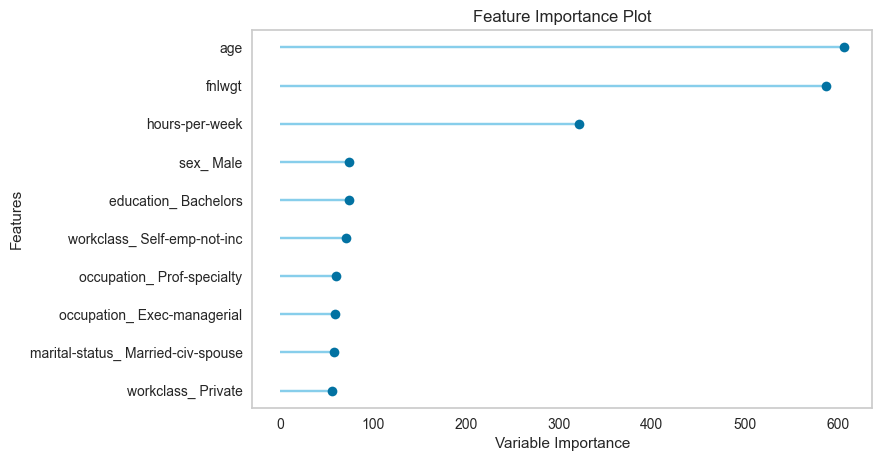

In [58]:
from pycaret.utils import check_metric

# Display feature and their importance
plot_model(tuned_LGBM, plot = 'feature')

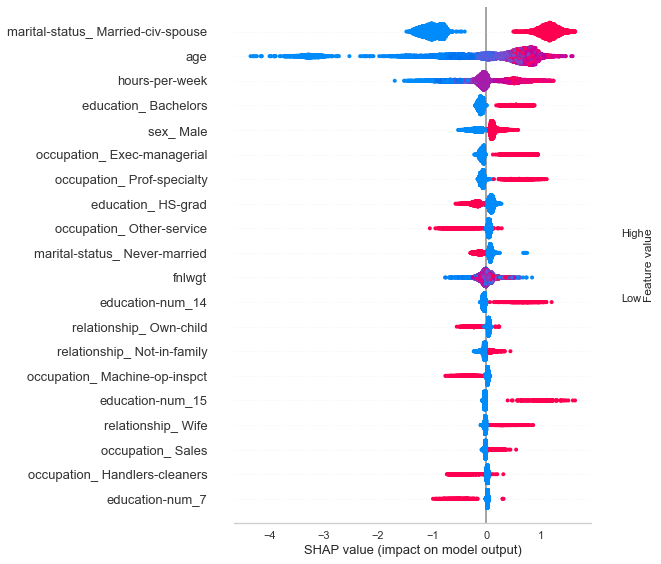

In [59]:
# Shap Model Interpretation Final Model
interpret_model(tuned_LGBM)

### GBC Classifier

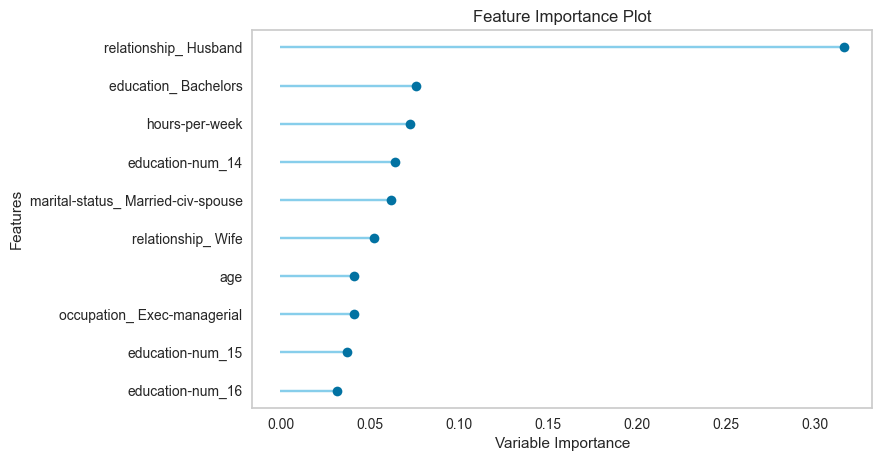

In [60]:
# Display feature and their importance
plot_model(tuned_GBC, plot = 'feature')

### Adaboost Classifier

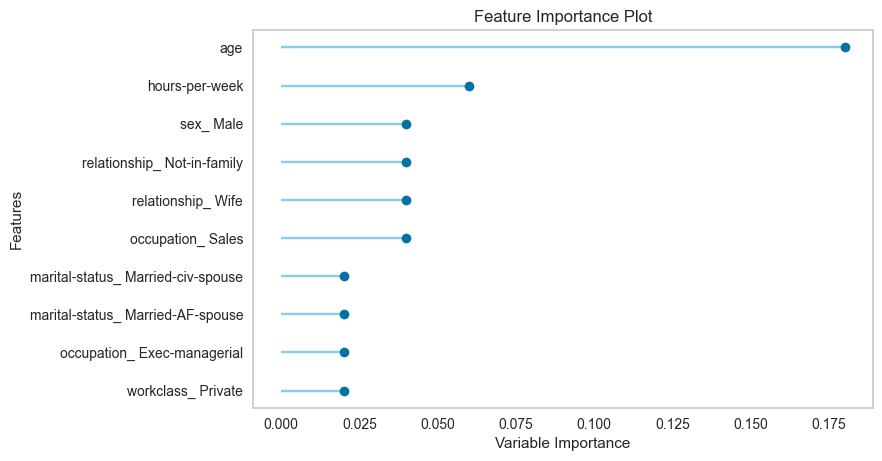

In [61]:
# Display feature and their importance
plot_model(tuned_ADA, plot = 'feature')

### Choosing The Best Model

In [62]:
best_model = tuned_LGBM
print(best_model)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=50, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


### Predicting Model on Test / Hold Out Sample

In [63]:
predict_model(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8409,0.8907,0.5969,0.6985,0.6437,0.5422,0.5449


,age,fnlwgt,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,...,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Male,income,Label,Score
0,0.45,0.891807,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0,0.7386
1,0.60,-0.553067,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,1,0.6931
2,-0.65,0.201516,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.9927
3,-0.05,0.268933,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0.9419
4,-0.10,0.393890,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,0,0.6802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9764,0.30,0.086651,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0.9921
9765,0.80,-0.187058,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,1,0.8749
9766,-0.35,-0.854063,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0,0.6006
9767,1.45,1.642367,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0.8538


### Classification Reports

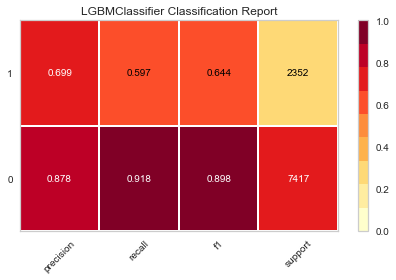

In [64]:
# Plotting the classification report
plot_model(best_model,plot='class_report')

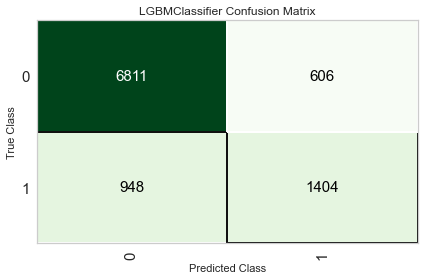

In [65]:
# Plotting the confusion matrix
plot_model(best_model,plot='confusion_matrix')

### Finalize Best Model

In [66]:
final_model = finalize_model(best_model)
print(final_model)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=50, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


### Predict On Unseen Data

In [67]:
# New Unseen Data
new_data = Income.copy()
unseen_predictions = predict_model(final_model, data=new_data)
unseen_predictions

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8580,0.9177,0.6317,0.7404,0.6817,0.5910,0.5941


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,Label,Score
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,0,0.9381
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,0,0.6797
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,0,0.9737
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0,0,0.8791
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,1,0.5979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0,0,0.7334
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1,0,0.7078
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0,0,0.9656
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0,0,0.9974
